<a href="https://colab.research.google.com/github/mailazorzan/email_classification_bert/blob/main/email_classification_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificacao de Spam em emails usando BERT

In [ ]:
# instalando tensorflow_text
!pip install tensorflow-text

In [ ]:
import tensorflow_hub as hub
import pandas as pd
import tensorflow_text as text
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix , classification_report
import seaborn as sns

In [ ]:
# load data
df_train = pd.read_csv('/content/drive/MyDrive/Portfolio/Spam BERT/spam_data.csv')

In [ ]:
df_train.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df_train['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [ ]:
df_train['Category'].value_counts(normalize=True)

ham     0.865937
spam    0.134063
Name: Category, dtype: float64

In [ ]:
# Re-balanceando as classes: vamos treinar o modelo 50/50, ou seja, com todos os positivos e o mesmo número de negativos.
df_spam = df_train[df_train['Category']=='spam']
print("Spam Dataset Shape:", df_spam.shape)

df_ham = df_train[df_train['Category']=='ham']
print("Ham Dataset Shape:", df_ham.shape)

Spam Dataset Shape: (747, 2)
Ham Dataset Shape: (4825, 2)


In [ ]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [ ]:
df_balanced = pd.concat([df_spam , df_ham_downsampled])
df_balanced.head()

,Category,Message
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
5,spam,FreeMsg Hey there darling it's been 3 week's n...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...
11,spam,"SIX chances to win CASH! From 100 to 20,000 po..."


In [ ]:
df_balanced['Category'].value_counts()

spam    747
ham     747
Name: Category, dtype: int64

In [ ]:
# One hot encoding
df_balanced['spam'] = df_balanced['Category'].apply(lambda x:1 if x=='spam' else 0)

In [ ]:
X_train, X_test , y_train, y_test = train_test_split(df_balanced['Message'], df_balanced['spam'],
                                                    stratify = df_balanced['spam'])

In [ ]:
y_train.value_counts()

1    560
0    560
Name: spam, dtype: int64

# Modelo

BERT:
- Preprocessa os dados de treino - incluindo token CLF, PAD e SEP para gerar `input_mask`, `input_type_ids`, `input_word_ids(token dado para cada palavra nas setences)` 

* OBs: o tamanho máximo de palavras na setença pode ser 128

## Download BERT
Parâmetros do modelo: 
- Layers - 12
- Hidden layers - 768 - embedding size
- Attention - 12
Name - Bert Small
---
Esse modelo possui 2 partes:
- Bert_preprocessor - pré processa o texto para estar nos moldes do BERT
- Bert_encoder - faz o encoding atual


In [ ]:
bert_preprocessor = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

## Processando e  encodando os dados

- Criamos um layer de entrada com shape e tipo: tf.string e nome `TEXT_INPUT`
- Passamos o `TEXT_INPUT` para o bert_prerocessor: `PREPROCESSED TEXT[*]`
- Passamos o texto pré processado para o encoder: `EMBEED`
- Passamos o pooled_outputs do EMBEED para o dropout layer: `DROPOUT`
- Criamos uma camada densa de ativação como `sigmoid`: `OUTPUTS`
- Criamos a saída do modelo: inputs - text_input, outputs - dropout

In [ ]:
import tensorflow as tf

In [ ]:
text_input = tf.keras.layers.Input(shape = (), dtype = tf.string, name = 'Inputs')
preprocessed_text = bert_preprocessor(text_input)
embeed = bert_encoder(preprocessed_text)
dropout = tf.keras.layers.Dropout(0.1, name = 'Dropout')(embeed['pooled_output'])
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'Dense')(dropout)

# criano o modelo final
model = tf.keras.Model(inputs = [text_input], outputs = [outputs])

In [ ]:
# checkando o summary do model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Inputs (InputLayer)            [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['Inputs[0][0]']                 
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

# Compilando o modelo

Optimizer - ADAM
Loss - binary_crossentropy
métricas - accuracy , precision and recall

In [ ]:
Metrics = [tf.keras.metrics.BinaryAccuracy(name = 'accuracy'),
           tf.keras.metrics.Precision(name = 'precision'),
           tf.keras.metrics.Recall(name = 'recall')
           ]

model.compile(optimizer ='adam',
               loss = 'binary_crossentropy',
               metrics = Metrics)

In [ ]:
#@title Optional 
# optional - defining tensorflow callbacks
import tensorflow as tf
import datetime
%load_ext tensorboard

!rm -rf ./logs/
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Treinando o modelo 

In [ ]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 298), started 2:33:58 ago. (Use '!kill 298' to kill it.)

<IPython.core.display.Javascript object>

In [ ]:
history = model.fit(X_train, y_train, epochs = 12 , callbacks = [tensorboard_callback])

Epoch 1/12
35/35 [==============================] - 67s 2s/step - loss: 0.6891 - accuracy: 0.5705 - precision: 0.5662 - recall: 0.6036
Epoch 2/12
35/35 [==============================] - 54s 2s/step - loss: 0.5278 - accuracy: 0.8071 - precision: 0.7945 - recall: 0.8286
Epoch 3/12
35/35 [==============================] - 54s 2s/step - loss: 0.4534 - accuracy: 0.8482 - precision: 0.8305 - recall: 0.8750
Epoch 4/12
35/35 [==============================] - 53s 2s/step - loss: 0.4078 - accuracy: 0.8562 - precision: 0.8634 - recall: 0.8464
Epoch 5/12
35/35 [==============================] - 53s 2s/step - loss: 0.3688 - accuracy: 0.8821 - precision: 0.8677 - recall: 0.9018
Epoch 6/12
35/35 [==============================] - 54s 2s/step - loss: 0.3490 - accuracy: 0.8902 - precision: 0.8787 - recall: 0.9054
Epoch 7/12
35/35 [==============================] - 54s 2s/step - loss: 0.3324 - accuracy: 0.8920 - precision: 0.8752 - recall: 0.9143
Epoch 8/12
35/35 [==============================] - 54s

# Avaliação do Modelo

In [ ]:
model.evaluate(X_test,y_test)

12/12 [==============================] - 11s 785ms/step - loss: 0.2555 - accuracy: 0.9358 - precision: 0.9267 - recall: 0.9465


[0.25545167922973633,
 0.9358288645744324,
 0.926701545715332,
 0.9465240836143494]

In [ ]:
y_pred = model.predict(X_test)
y_pred = y_pred.flatten()

In [ ]:
y_pred = np.where(y_pred>0.5,1,0 )
y_pred 

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,

Text(33.0, 0.5, 'Actual')

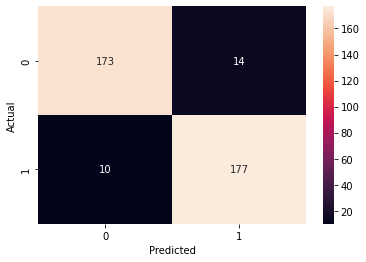

In [ ]:
cm = confusion_matrix(y_test,y_pred)
cm
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [ ]:
print(classification_report(y_test , y_pred))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       187
           1       0.93      0.95      0.94       187

    accuracy                           0.94       374
   macro avg       0.94      0.94      0.94       374
weighted avg       0.94      0.94      0.94       374



# Predição

In [ ]:
predict_text = [
                # Spam
                'We’d all like to get a $10,000 deposit on our bank accounts out of the blue, but winning a prize—especially if you’ve never entered a contest', 
                'Netflix is sending you a refund of $12.99. Please reply with your bank account and routing number to verify and get your refund', 
                'Your account is temporarily frozen. Please log in to to secure your account ', 

                #ham
                'The article was published on 18th August itself',
                'Although we are unable to give you an exact time-frame at the moment, I would request you to stay tuned for any updates.',
                'The image you sent is a UI bug, I can check that your article is marked as regular and is not in the monetization program.'
]

In [ ]:
test_results = model.predict(predict_text)

In [ ]:
output = np.where(test_results>0.5,'spam', 'ham') 

In [ ]:
output

array([['spam'],
       ['spam'],
       ['spam'],
       ['ham'],
       ['spam'],
       ['spam']], dtype='<U4')

# Similaridade entre textos

In [ ]:
def get_embedding(sentence_arr):
    'takes in sentence array and return embedding vector'
    preprocessed_text = bert_preprocessor(sentence_arr)
    embeddings = bert_encoder(preprocessed_text)['pooled_output']
    return embeddings

In [ ]:
e = get_embedding([
               'We’d all like to get a $10,000 deposit on our bank accounts out of the blue, but winning a prize—especially if you’ve never entered a contest',
               'The image you sent is a UI bug, I can check that your article is marked as regular and is not in the monetization program.'
])

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
# check similarity score
print('4@$'Similarity score between 1st sentence(spam) and second sentence(spam) : {cosine_similarity([e[0]] , [e[1]])}')

Similarity score between 1st sentence(spam) and second sentence(spam) : [[0.85391873]]
